In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [31]:
'''Correction'''
scripts = []
with open("data/all_scripts.txt", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith(">>"):
            episode = line[2:].strip()
            season = episode.split(" ")[1]
        elif line.startswith(">"):
            scene = line[1:].strip()
        else:
            character, dialogue = line.strip().split(":", 1)
            dialogue = dialogue.strip()
            scripts.append([season, episode, scene, character, dialogue])
df = pd.DataFrame(scripts, columns=["season", "episode", "scene", "character", "dialogue"])
display(df)

,season,episode,scene,character,dialogue
0,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.
...,...,...,...,...,...
51287,10,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Ramona,"Mmm. No big deal, I enjoy spending time with you."
51288,10,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Sheldon,"And I with you. Question, are you seeking a ro..."
51289,10,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Ramona,What if I were?
51290,10,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Sheldon,"Well, that would raise a number of problems. W..."


In [35]:
'''Correction'''
df[["season", "episode", "scene"]].drop_duplicates(["episode", "scene"]).groupby("season")[["scene"]].count()

,scene
season,
01,157
02,205
03,193
04,219
05,198
06,211
07,207
08,191
09,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [55]:
# your code goes here
# recurrent characters: (1) appear in more than 1 episode, (2) have >90 lines
mask_episodes = df.copy().groupby("character")["episode"].transform("nunique") >= 1
mask_lines    = df.copy().groupby("character").transform("size") > 90
recur_characters = df["character"][mask_episodes & mask_lines].drop_duplicates().to_frame()
recur_characters

,character
0,Sheldon
1,Leonard
43,Penny
195,Howard
196,Raj
274,Man
919,Mrs Cooper
3088,Leslie
6761,Kripke
7365,Beverley


In [58]:
'''Correction'''
recur_characters = recur_characters[recur_characters.character != "Man"]

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [51]:
# your code goes here
def remove_punc_and_lower(row):
    row = [char.lower() for char in row if char not in EXCLUDE_CHARS]
    return "".join(row)

df_preprocessed = df.copy()
df_preprocessed["dialogue"] = df_preprocessed["dialogue"].apply(remove_punc_and_lower)
df_preprocessed.head()

,season,episode,scene,character,dialogue
0,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...
1,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed whats your point
2,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,theres no point i just think its a good idea f...
3,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me
4,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

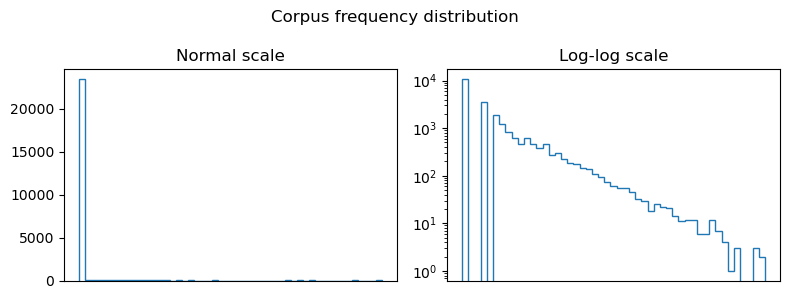

In [52]:
# your code goes here
from collections import Counter

corpus = " ".join(df_preprocessed["dialogue"].tolist())
vocabulary = Counter(corpus.split())
freq = list(vocabulary.values())

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle("Corpus frequency distribution")
axs[0].hist(freq, bins=50, histtype="step")
axs[0].set_xticks([])
axs[0].set_title("Normal scale")

logbins = np.linspace(np.log(freq).min(), np.log(freq).max(), 50)
axs[1].hist(np.log(freq), bins=logbins, histtype="step", log=True)
axs[1].set_xticks([])
axs[1].set_title("Log-log scale")
plt.tight_layout()
plt.show()

**Observation:** Corpus frequency follows a heavy-tailed distribution. Log-log scale is appropriate for plotting this kind of distribution.

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [59]:
# your code goes here
num_words = []
for character in recur_characters["character"]:
    words = " ".join(df.copy().groupby("character").get_group(character)["dialogue"].tolist())
    num_words.append(len(words.split()))
recur_characters["num_words"] = num_words
recur_characters

,character,num_words
0,Sheldon,174911
1,Leonard,95608
43,Penny,74247
195,Howard,64988
196,Raj,56390
919,Mrs Cooper,3205
3088,Leslie,1164
6761,Kripke,1163
7365,Beverley,1918
8534,Stuart,7407


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [60]:
# your code goes here
def get_dataset(df, split, vocabulary=None):
    mask = df["episode"].str.startswith(split)
    lines_split = df[mask]["dialogue"]
    y_split = df[mask]["character"].map(lambda x: 1 if x=="Sheldon" else 0)
    
    X = get_tfidf(df_preprocessed["dialogue"].tolist(), vocabulary)
    X = dim_reduction(X)
    X_split = X[:sum(mask), :]
    return lines_split, X_split, y_split

def get_tfidf(corpus, vocabulary=None):
    vectorizer = TfidfVectorizer(vocabulary=vocabulary)
    tfidf = vectorizer.fit_transform(corpus)
    return tfidf

def dim_reduction(X):
    svd = TruncatedSVD(n_components=100, random_state=42)
    return svd.fit_transform(X)

train_split = tuple("Series 0" + str(sid) for sid in range(9))
test_split = tuple(["Series 09", "Series 10"])
train_lines, train_X, train_y = get_dataset(df_preprocessed, train_split)
test_lines, test_X, test_y = get_dataset(df_preprocessed, test_split)
print("Dimension of features: %.0f" % train_X.shape[1])

Dimension of features: 100


**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [61]:
# your code goes here
vocab_sheldon = set(word for line in train_lines[train_y == 1].tolist() for word in line.split())
vocab_others  = set(word for line in train_lines[train_y == 0].tolist() for word in line.split())
vocab_sheldon_unique = vocab_sheldon - vocab_others
print("Number of words only uttered by Sheldon: %.0f" % len(vocab_sheldon_unique))

Number of words only uttered by Sheldon: 5658


In [62]:
model = LogisticRegressionCV()
model.fit(train_X, train_y)
test_y_pred = model.predict(test_X)
accuracy = sum(test_y_pred == test_y) / len(test_y)
print("Accuracy: %.2f" % accuracy)

Accuracy: 0.79
